In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv


In [25]:
# Load the data
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")

1    2266
3    2080
7    2070
2    2010
6    1982
9    1980
4    1971
0    1932
8    1915
5    1794
Name: label, dtype: int64

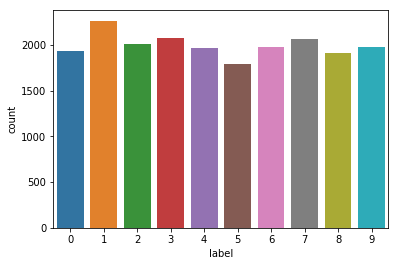

In [26]:
Y_train = train["label"][:20000]
Y_dev = train["label"][20000:22500]
# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) [:20000]
X_dev = train.drop(labels = ["label"],axis = 1) [20000:22500]


# free some space
del train 

g = sns.countplot(Y_train)

Y_train.value_counts()

In [27]:
# Normalize the data
X_train = X_train / 255.0
X_dev = X_dev / 255.0

test = test / 255.0 
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
X_dev = X_dev.values.reshape(-1,28,28,1)

test = test.values.reshape(-1,28,28,1)

true label : 4


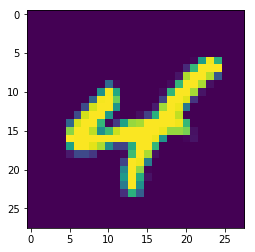

In [28]:
g = plt.imshow(X_train[1801][:,:,0])
print('true label : {}'.format(Y_train[1801]))

In [29]:
class conv():
    def __init__(self,n_filters):
        self.n_filters=n_filters
        self.filters=np.random.randn(n_filters,3,3)/9
    def forward(self,input_image):
        self.input_image=input_image
        output = np.zeros((input_image.shape[0]-3+1,input_image.shape[1]-3+1,self.n_filters))
        self.retrieve=dict()
        for i in range(input_image.shape[0]-3+1):
            for j in range (input_image.shape[1]-3+1):
                retrieved_image=input_image[i:i+3,j:j+3,0]
                output[i,j]=np.sum(np.sum(retrieved_image*self.filters,axis=1),axis=1) #element wise product and sum
                self.retrieve[(i,j)]=retrieved_image
        return output
    def backward(self,last_gradients,lr=.005):
        new_last_gradients=np.zeros(self.filters.shape)
        for i in range(self.input_image.shape[0]-3+1):
            for j in range(self.input_image.shape[1]-3+1):    
                for f in range (self.n_filters):
                    new_last_gradients[f]+=last_gradients[i,j,f]*self.retrieve[(i,j)]
        self.filters -= lr * new_last_gradients
        return new_last_gradients

In [7]:
######################
## sgd
######################
# class conv_sgd():
#     def __init__(self,n_filters,batch_size):
#         self.n_filters=n_filters
#         self.batch_size=batch_size
#         self.filters=np.random.randn(n_filters,3,3)/9
#         self.gradients=[]
#     def forward(self,input_image):
#         self.input_image=input_image
#         output = np.zeros((input_image.shape[0]-3+1,input_image.shape[1]-3+1,self.n_filters))
#         self.retrieve=dict()
#         for i in range(input_image.shape[0]-3+1):
#             for j in range (input_image.shape[1]-3+1):
#                 retrieved_image=input_image[i:i+3,j:j+3,0]
#                 output[i,j]=np.sum(np.sum(retrieved_image*self.filters,axis=1),axis=1) #element wise product and sum
#                 self.retrieve[(i,j)]=retrieved_image
#         return output
#     def backward(self,counter,last_gradients,lr=.005):
#         new_last_gradients=np.zeros(self.filters.shape)
#         for i in range(self.input_image.shape[0]-3+1):
#             for j in range(self.input_image.shape[1]-3+1):    
#                 for f in range (self.n_filters):
#                     new_last_gradients[f]+=last_gradients[i,j,f]*self.retrieve[(i,j)]
#         self.gradients.append(new_last_gradients)
#         if counter%self.batch_size==self.batch_size-1:
# #             print(True)
#             g=np.mean(np.array(self.gradients))
#             self.filters -= lr * g
#             self.gradients=[]
#         return new_last_gradients

In [30]:
class maxpooling():
    def __init__(self,pool_size):
        self.pool_size=pool_size
        self.indices=None
    def forward(self,input_image):
        self.input_image=input_image
        self.binary_matrix=np.zeros(input_image.shape)
        d1,d2,n_filters=input_image.shape
        output=np.zeros((d1//2,d2//2,n_filters))
        indices=[]
        for i in range(d1//2):
            for j in range(d2//2):
                    output[i,j]=input_image[i*2:(i+1)*2,j*2:(j+1)*2].max(axis=(0,1))
                    indices=input_image[i*2:(i+1)*2,j*2:(j+1)*2].argmax(axis=0)  #or axis=1
                    #construction of a binary matrix
                    for f in range (n_filters):
                        i_=indices[0][f]
                        j_=indices[1][f]
                        self.binary_matrix[i*2+i_,j*2+j_,f]=1
        return output
    def backward(self,last_gradients):
        d1,d2,n_filters=self.input_image.shape
        new_last_gradients=np.zeros((2,2))
        for i,arr in enumerate(np.ndarray.flatten(last_gradients)):
            new_last_gradients=np.vstack((new_last_gradients,np.full((2,2),arr)))
        new_last_gradients=new_last_gradients[2:].reshape(last_gradients.shape[0]*2,last_gradients.shape[1]*2,last_gradients.shape[2])
        new_last_gradients=new_last_gradients * self.binary_matrix
        return new_last_gradients

In [31]:
class fully_connected():
    def __init__(self,input_dimension,output_neurons):
        self.input_dimension=input_dimension
        self.output_neurons=output_neurons
        self.weights=np.random.randn(input_dimension,output_neurons)/input_dimension
        self.biases=np.random.randn(output_neurons)
    def flatten(self,input):
        return input.flatten()
    def forward(self,input_image):
        self.last_shape=input_image.shape
        input_image = self.flatten(input_image)
        self.previous_input=input_image
        output=np.dot(input_image,self.weights)+self.biases
        output=np.exp(output)
        self.output_exp=output
        self.output_s=output/np.sum(output,axis=0)
        self.sum=np.sum(output,axis=0)
        return output/np.sum(output,axis=0)
    def backward(self,input_image,label,lr=0.005):
        output = conv_.forward(input_image)
        output = pool.forward(output)
        output=self.forward(output)
        grads=np.zeros(10)
        grads[label]=-1/output[label]
        for i in range(len(grads)):
            if grads[i]==0:
                continue
            else:
                # Grads output softmax/input softmax
                d_outs_inps=-self.output_s[i]*self.output_s
                d_outs_inps[i]=self.output_exp[i]*(self.sum-self.output_exp[i])/(self.sum)**2 #Compute gradients for softmax input and output
                #grads input softmax/Weights;biases,previous input(after flatten)
                d_inps_weights=self.previous_input
                d_inps_b=1
                d_inps_input=self.weights
                #Final gradients
                d_L_inps=grads[i]*d_outs_inps
                
                d_L_weights=d_inps_weights[np.newaxis].T @ d_L_inps[np.newaxis]
                d_L_biases=d_L_inps * d_inps_b
                d_L_inputs=d_inps_input @ d_L_inps
                
            self.weights -= lr * d_L_weights
            self.biases -= lr * d_L_biases
                
        return d_L_inputs.reshape(self.last_shape)

In [13]:
######################
## sgd
######################
# class fully_connected_sgd():
#     def __init__(self,input_dimension,output_neurons,batch_size):
#         self.batch_size=batch_size
#         self.input_dimension=input_dimension
#         self.output_neurons=output_neurons
#         self.weights=np.random.randn(input_dimension,output_neurons)/input_dimension
#         self.weights_memory=[]
#         self.biases=np.random.randn(output_neurons)
#         self.biases_memory=[]
#     def flatten(self,input):
#         return input.flatten()
#     def forward(self,input_image):
#         self.last_shape=input_image.shape
#         input_image = self.flatten(input_image)
#         self.previous_input=input_image
#         output=np.dot(input_image,self.weights)+self.biases
#         output=np.exp(output)
#         self.output_exp=output
#         self.output_s=output/np.sum(output,axis=0)
#         self.sum=np.sum(output,axis=0)
#         return output/np.sum(output,axis=0)
#     def backward(self,counter,input_image,label,lr=0.005):
#         output = conv_.forward(input_image)
#         output = pool.forward(output)
#         output=self.forward(output)
#         grads=np.zeros(10)
#         grads[label]=-1/output[label]
#         for i in range(len(grads)):
#             if grads[i]==0:
#                 continue
#             else:
#                 # Grads output softmax/input softmax
#                 d_outs_inps=-self.output_s[i]*self.output_s
#                 d_outs_inps[i]=self.output_exp[i]*(self.sum-self.output_exp[i])/(self.sum)**2 #Compute gradients for softmax input and output
#                 #grads input softmax/Weights;biases,previous input(after flatten)
#                 d_inps_weights=self.previous_input
#                 d_inps_b=1
#                 d_inps_input=self.weights
#                 #Final gradients
#                 d_L_inps=grads[i]*d_outs_inps
                
#                 d_L_weights=d_inps_weights[np.newaxis].T @ d_L_inps[np.newaxis]
#                 d_L_biases=d_L_inps * d_inps_b
#                 d_L_inputs=d_inps_input @ d_L_inps
#         self.weights_memory.append(d_L_weights)
#         self.biases_memory.append(d_L_biases)
#         if counter%self.batch_size==self.batch_size-1:
#             self.weights -= lr * d_L_weights
#             self.biases -= lr * d_L_biases
                
#         return d_L_inputs.reshape(self.last_shape)

In [32]:
def cross_entropy_loss(output,true_label):
    return -np.log(output[true_label])
    
def accuracy(output,true_label):
    predicted_class=np.argmax(output)
    if predicted_class==true_label:
        return 1
    else :
        return 0
# true_label=Y_train[0]
# print('loss = {}'.format(cross_entropy_loss(output,true_label))) 
# print('accuracy = {}'.format(accuracy(output,true_label))) 

In [33]:
conv_ = conv(8)
pool = maxpooling(2)
fully_c=fully_connected(13*13*8,10)

def forward(image, label):
  '''
  Completes a forward pass of the CNN and calculates the accuracy and
  cross-entropy loss.
  - image is a 2d numpy array
  - label is a digit
  '''
  # We transform the image from [0, 255] to [-0.5, 0.5] to make it easier
  # to work with. This is standard practice.
  out = conv_.forward(image)
  out = pool.forward(out)
  out = fully_c.forward(out)

  # Calculate cross-entropy loss and accuracy. np.log() is the natural log.
  loss = -np.log(out[label])
#   print(out[label])
  acc = 1 if np.argmax(out) == label else 0

  return out, loss, acc

In [34]:
def predict(image):
    
    out = conv_.forward(image)
    out = pool.forward(out)
    out = fully_c.forward(out)
    return np.argmax(out) 

In [17]:
######################
## sgd
######################
# def train(im, label,counter):
#   '''
#   Completes a full training step on the given image and label.
#   Returns the cross-entropy loss and accuracy.
#   - image is a 2d numpy array
#   - label is a digit
#   - lr is the learning rate
#   '''
#   # Forward
#   out, loss, acc = forward(im, label)


#   # Calculate initial gradient
# #   gradient = np.zeros(10)
# #   gradient[label] = -1 / out[label]

#   # Backprop
#   gradient = fully_c.backward(counter,im,label)
#   gradient_2 = pool.backward(gradient)
#   gradient_3 = conv_.backward(counter,gradient_2)

#   return loss, acc 

# print('MNIST CNN initialized!')

# # Train!
# loss = 0
# num_correct = 0
# for i, (im, label) in enumerate(zip(X_train, Y_train)):
# #   print(label)
#   if i % 32 == 31:
#     print('[Step %d] Past batch: Average Loss %.3f | Accuracy: %d%%' %(i + 1, loss / 32, num_correct/32*100))
#     loss = 0
#     num_correct = 0

#   l, acc = train(im, label,i)
#   loss += l
#   num_correct += acc

In [35]:

def train(im, label):
  '''
  Completes a full training step on the given image and label.
  Returns the cross-entropy loss and accuracy.
  - image is a 2d numpy array
  - label is a digit
  - lr is the learning rate
  '''
  # Forward
  out, loss, acc = forward(im, label)
  # Backprop
  gradient = fully_c.backward(im,label)
  gradient_2 = pool.backward(gradient)
  gradient_3 = conv_.backward(gradient_2)

  return loss, acc 

print('MNIST CNN initialized!')

# Train!
n_epochs=2
losses=[]
accs=[]
steps=[]
loss = 0
num_correct = 0
for i, (im, label) in enumerate(zip(X_train, Y_train)):
#   print(label)
  if i % 100 == 99:
    print('[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %(i + 1, loss / 100, num_correct))
    losses.append(loss/100)
    accs.append(num_correct)
    steps.append(i)
    loss = 0
    num_correct = 0

  l, acc = train(im, label)
  loss += l
  num_correct += acc

MNIST CNN initialized!
[Step 100] Past 100 steps: Average Loss 2.595 | Accuracy: 5%
[Step 200] Past 100 steps: Average Loss 2.337 | Accuracy: 12%
[Step 300] Past 100 steps: Average Loss 2.253 | Accuracy: 8%
[Step 400] Past 100 steps: Average Loss 2.136 | Accuracy: 29%
[Step 500] Past 100 steps: Average Loss 2.082 | Accuracy: 31%
[Step 600] Past 100 steps: Average Loss 1.960 | Accuracy: 41%
[Step 700] Past 100 steps: Average Loss 1.935 | Accuracy: 46%
[Step 800] Past 100 steps: Average Loss 1.882 | Accuracy: 55%
[Step 900] Past 100 steps: Average Loss 1.660 | Accuracy: 71%
[Step 1000] Past 100 steps: Average Loss 1.569 | Accuracy: 68%
[Step 1100] Past 100 steps: Average Loss 1.621 | Accuracy: 63%
[Step 1200] Past 100 steps: Average Loss 1.558 | Accuracy: 68%
[Step 1300] Past 100 steps: Average Loss 1.440 | Accuracy: 79%
[Step 1400] Past 100 steps: Average Loss 1.332 | Accuracy: 82%
[Step 1500] Past 100 steps: Average Loss 1.268 | Accuracy: 73%
[Step 1600] Past 100 steps: Average Loss 1.

[Step 13100] Past 100 steps: Average Loss 0.585 | Accuracy: 84%
[Step 13200] Past 100 steps: Average Loss 0.593 | Accuracy: 86%
[Step 13300] Past 100 steps: Average Loss 0.414 | Accuracy: 90%
[Step 13400] Past 100 steps: Average Loss 0.409 | Accuracy: 91%
[Step 13500] Past 100 steps: Average Loss 0.587 | Accuracy: 82%
[Step 13600] Past 100 steps: Average Loss 0.443 | Accuracy: 85%
[Step 13700] Past 100 steps: Average Loss 0.366 | Accuracy: 89%
[Step 13800] Past 100 steps: Average Loss 0.326 | Accuracy: 89%
[Step 13900] Past 100 steps: Average Loss 0.291 | Accuracy: 91%
[Step 14000] Past 100 steps: Average Loss 0.287 | Accuracy: 93%
[Step 14100] Past 100 steps: Average Loss 0.366 | Accuracy: 90%
[Step 14200] Past 100 steps: Average Loss 0.365 | Accuracy: 91%
[Step 14300] Past 100 steps: Average Loss 0.441 | Accuracy: 88%
[Step 14400] Past 100 steps: Average Loss 0.391 | Accuracy: 84%
[Step 14500] Past 100 steps: Average Loss 0.402 | Accuracy: 84%
[Step 14600] Past 100 steps: Average Los

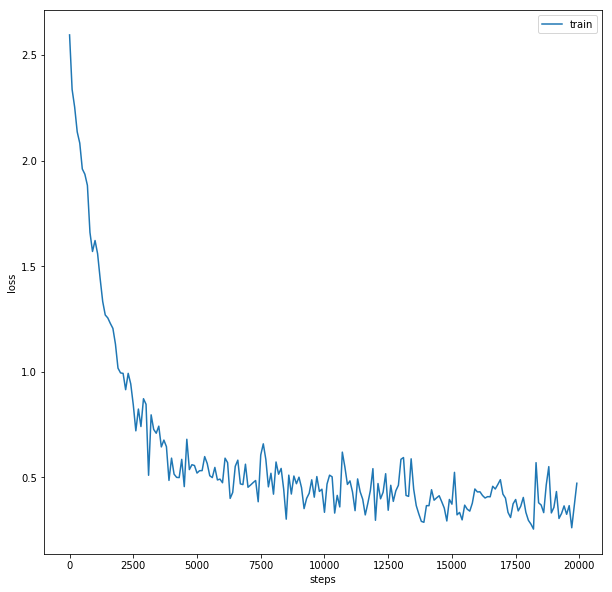

In [38]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(0,len(accs)*100,100),losses,label='train')
# plt.plot(np.arange(0,100),np.ones(100)*20,label='test')
plt.legend()
plt.xlabel('steps')
plt.ylabel('loss')
plt.savefig('acc.png')

In [36]:
# Test the CNN
print('\n--- Testing the CNN ---')
loss = 0
losses_test=[]
accs_test=[]
num_correct = 0
for im, label in zip(X_dev, Y_dev):
  _, l, acc = forward(im, label)
  loss += l
  losses_test.append(l)
  num_correct += acc

plt.figure(figsize=(10,10))
plt.plot(np.arange(0,len(accs)*100,100),losses,label='train')
# plt.plot(np.arange(0,100),np.ones(100)*20,label='test')
num_tests = len(X_dev)
print('Test Loss:', loss / num_tests)
print('Test Accuracy: {} %'.format( num_correct / num_tests))


--- Testing the CNN ---
Test Loss: 0.39685995470548774
Test Accuracy: 0.8892 %


In [ ]:
# Test the CNN
print('\n--- Testing the CNN ---')
predictions=[]
for im in test:
  predictions.append(predict(im))


--- Testing the CNN ---


In [ ]:
results = pd.Series(predictions,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)